### Import some packages and data

In [1]:
import numpy as np
import cvxopt as cvx
import picos as pic
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import array
f = open('faces','r')
faces = np.load(f)
f.close()

### We generate a signal, and its noisy (corrupted) version

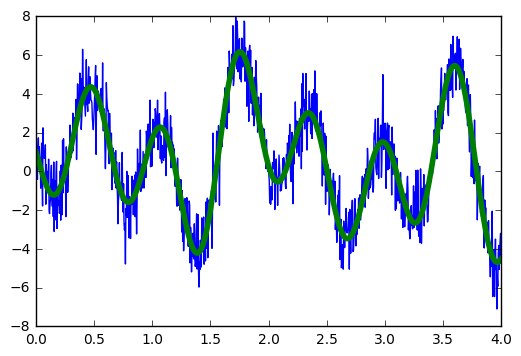

In [2]:
xxx = np.linspace(0,4,1000)
f = lambda x: np.sin(x)+2*np.sin(4*x)-3*np.sin(10*x)+np.cos(7*x)
fff = np.array([f(x) for x in xxx])
f_cor = np.array([f(x)+np.random.randn() for x in xxx])
plt.plot(xxx,f_cor)
plt.plot(xxx,fff,linewidth=4)

### Construct the smoothing matrix $D$

In [3]:
n = fff.shape[0]
D = cvx.matrix(0.,(n-1,n))
for i in range(n-1):
    D[i,i]=1
    D[i,i+1]=-1

### Solve the quadratic smoothing problem

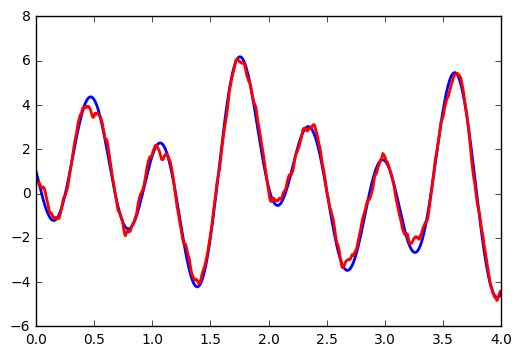

In [4]:
P = pic.Problem()
ff_cor = pic.new_param('f_cor',f_cor)
ff = P.add_variable('ff',n)
t = P.add_variable('t',1)
u = P.add_variable('u',1)

P.add_constraint(pic.norm(ff-ff_cor,2) <= t)
P.add_constraint(pic.norm(D*ff,2) <= u)
P.set_objective('min',t+3*u)
P.solve(verbose=False)
plt.plot(xxx,fff,linewidth=2)
plt.plot(xxx,ff.value,linewidth=2,color='red')

### Now we do it for a signal with sharp transitions

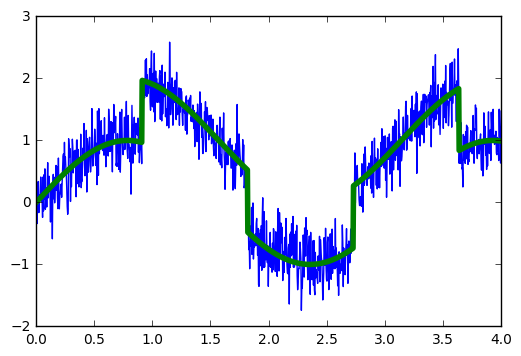

In [5]:
f = lambda x: np.sin(2*x)+(int(1.1*x) % 2)
fff = np.array([f(x) for x in xxx])
f_cor = np.array([f(x)+0.3*np.random.randn() for x in xxx])
plt.plot(xxx,f_cor)
plt.plot(xxx,fff,linewidth=4)


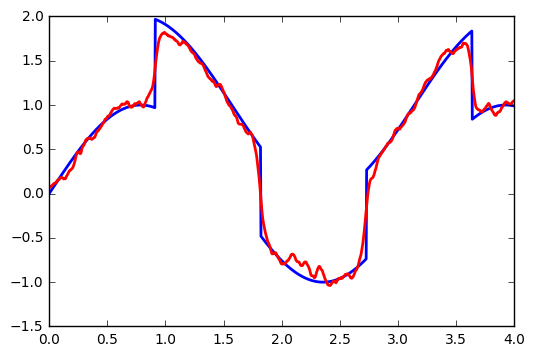

In [6]:
ff_cor = pic.new_param('f_cor',f_cor)

P = pic.Problem()
ff = P.add_variable('ff',n)
t = P.add_variable('t',1)
u = P.add_variable('u',1)
P.add_constraint(pic.norm(ff-ff_cor,2) <= t)
P.add_constraint(pic.norm(D*ff,2) <= u)
P.set_objective('min',t+3*u)
P.solve(verbose=False)

plt.plot(xxx,fff,linewidth=2)
plt.plot(xxx,ff.value,linewidth=2,color='red')

### OK, but we sharp transitions have been smoothed, too.
#### Let's try we the L1-norm (minimize "total variation")

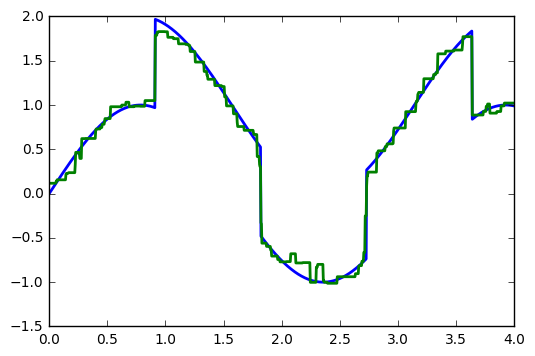

In [7]:
P_TV = pic.Problem()
ff_TV = P_TV.add_variable('ff',n)
t = P_TV.add_variable('t',1)
u = P_TV.add_variable('u',1)
P_TV.add_constraint(pic.norm(ff_TV-ff_cor,2) <= t)
P_TV.add_constraint(pic.norm(D*ff_TV,1) <= u)
P_TV.set_objective('min',t+0.1*u)
P_TV.solve(verbose=False)

plt.plot(xxx,fff,linewidth=2)
plt.plot(xxx,ff_TV.value,linewidth=2,color='green')

### OK, so a good idea is probably to minimize a combination of L1- and L2-norm

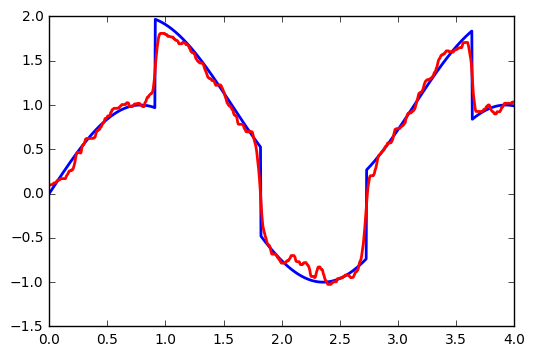

In [8]:
P = pic.Problem()
ff = P.add_variable('ff',n)
t = P.add_variable('t',1)
u1 = P.add_variable('u1',1)
u2 = P.add_variable('u2',1)
P.add_constraint(pic.norm(ff-ff_cor,2) <= t)
P.add_constraint(pic.norm(D*ff,1) <= u1)
P.add_constraint(pic.norm(D*ff,2) <= u2)
P.set_objective('min',t+0.04*u1+1.8*u2)
P.solve(verbose=False)

plt.plot(xxx,fff,linewidth=2)
plt.plot(xxx,ff.value,linewidth=2,color='red')

# -------------------------------------------------------------------------------

### Now we try it we a 2d-signal (a picture)

### Choose an image (index between $i=0$ and $i=399$)

In [9]:
i = 160
image = 1-faces[i]
print image

[[ 0.56611574  0.53305781  0.47520661 ...,  0.70247936  0.70247936
   0.72727275]
 [ 0.59090912  0.54132235  0.4834711  ...,  0.73966944  0.69834709
   0.70247936]
 [ 0.60743803  0.53305781  0.48760331 ...,  0.71900827  0.71900827
   0.68181819]
 ..., 
 [ 0.6570248   0.51239669  0.4834711  ...,  0.83057851  0.82231402
   0.83057851]
 [ 0.57024795  0.50826442  0.49173552 ...,  0.82644629  0.82644629
   0.83057851]
 [ 0.54132235  0.51652896  0.49586779 ...,  0.82644629  0.83057851
   0.83057851]]


### So, the image is in fact an array of pixels, with intensity between 0 (white pixel ) and 1 (black pixel)
#### Let us now see what this image looks like...

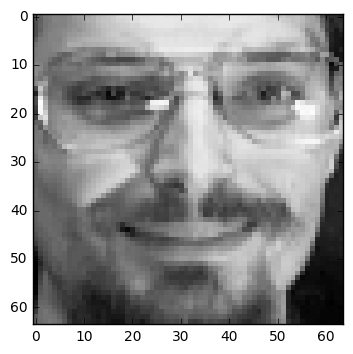

In [10]:
def show_image(img,ax=None,title=None):
    if ax is None:
        ax = plt.gca()
    ax.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
    if title:
        ax.set_title(title)
show_image(image)

### Now, we add some noise to the image, and we display the noisy image

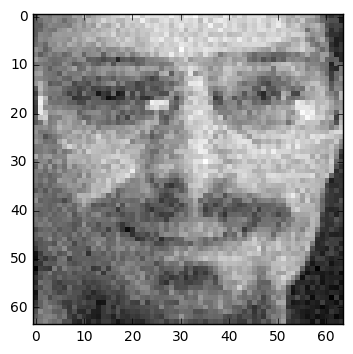

In [11]:
n,m = image.shape
noisy_image = np.array(image)
noisy_image = noisy_image + 0.05 * np.random.randn(n,m)
noisy_image = np.maximum(np.minimum(noisy_image,1.),0.)
show_image(noisy_image)

In [97]:
noisy_image

array([[ 0.566425  ,  0.58325547,  0.54168576, ...,  0.71553055,
         0.77774356,  0.73313369],
       [ 0.5898511 ,  0.50018617,  0.44105353, ...,  0.71458178,
         0.77290955,  0.77610662],
       [ 0.5435651 ,  0.54615503,  0.54134696, ...,  0.70918384,
         0.81159679,  0.68851373],
       ..., 
       [ 0.61660143,  0.50024503,  0.44820484, ...,  0.8153206 ,
         0.77834739,  0.82004612],
       [ 0.58715799,  0.59167093,  0.41613088, ...,  0.74764697,
         0.89385877,  0.78618627],
       [ 0.50984353,  0.41835809,  0.42021256, ...,  0.84007792,
         0.87040862,  0.88476232]])

### Construct the smooting matrix $D$ from the regularizing term $\phi(X) = \lambda \Vert D\, X[:] \Vert$
In python, `X[:]` represents the vectorization of `X`:

if `X` is a $n \times m$ matrix, then `X[:]` is a vector of dimension $nm$, obtained by stacking vertically the $m$ columns of `X`.

In [12]:
#We first store the rows of the matrix D in a list,
# and this list of rows is transformed into a matrix at the end of this cell.

D = []
for i in range(n-1):
    for j in range(m):
        v = [0]*n*m
        v[n*j+i]=1
        v[n*j+i+1]=-1
        D.append(v)
for i in range(n):
    for j in range(m-1):
        v = [0]*n*m
        v[n*j+i]=1
        v[n*(j+1)+i]=-1
        D.append(v)

D = cvx.matrix(D).T

### Construct the optimization problem, as a function of the multipliers $\lambda_1$ and $\lambda_2$

In [13]:
import picos as pic

def smooth_image(lbda1,lbda2):
    P = pic.Problem()
    X = P.add_variable('X',(n,m))
    t = P.add_variable('t',1)
    u1 = P.add_variable('u1',1)
    u2 = P.add_variable('u2',1)

    X_noisy = pic.new_param('Xnoisy',noisy_image)
    P.add_constraint(pic.norm(X-X_noisy,2) <= t)
    P.add_constraint(pic.norm(D*X[:],1) <= u1)
    P.add_constraint(pic.norm(D*X[:],2) <= u2)
    P.add_constraint(X >= 0)
    P.add_constraint(X <= 1)
    P.set_objective('min',t + lbda1 * u1 + lbda2 * u2)
    P.solve(verbose=False)
    return X.value

### Show the denoised face

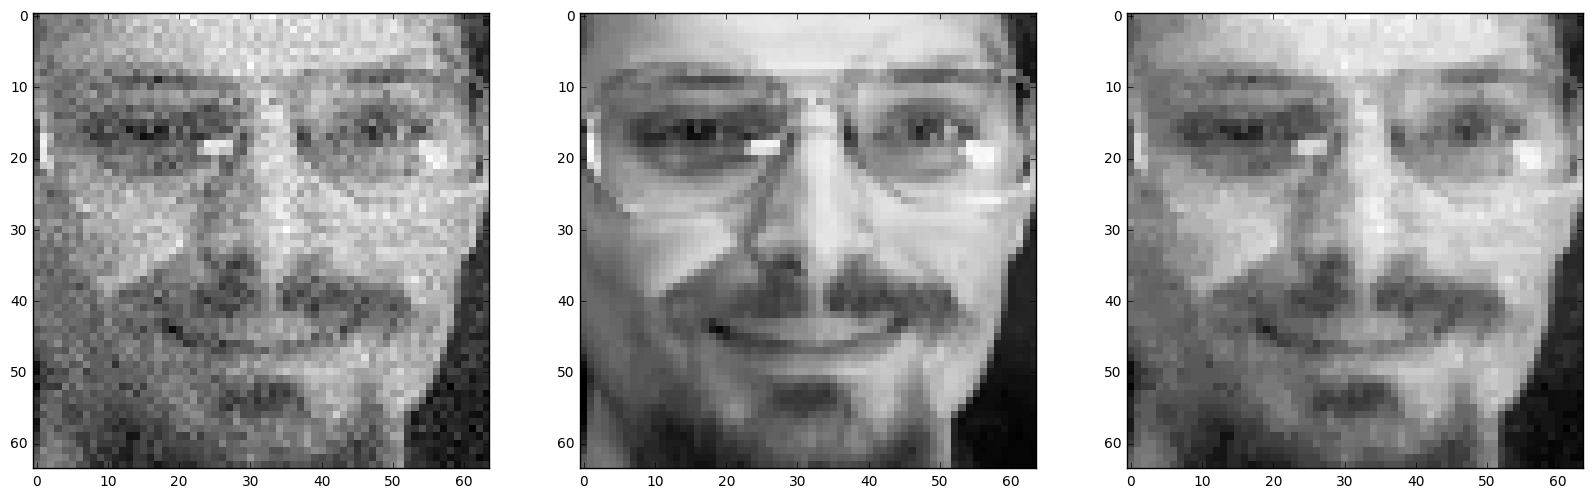

In [20]:
fig=plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(131)
show_image(noisy_image,ax1)
ax2 = fig.add_subplot(132)
show_image(image,ax2)
ax3 = fig.add_subplot(133)
show_image(smooth_image(0.004,0.4),ax3)

### Show result for several values of the multipliers

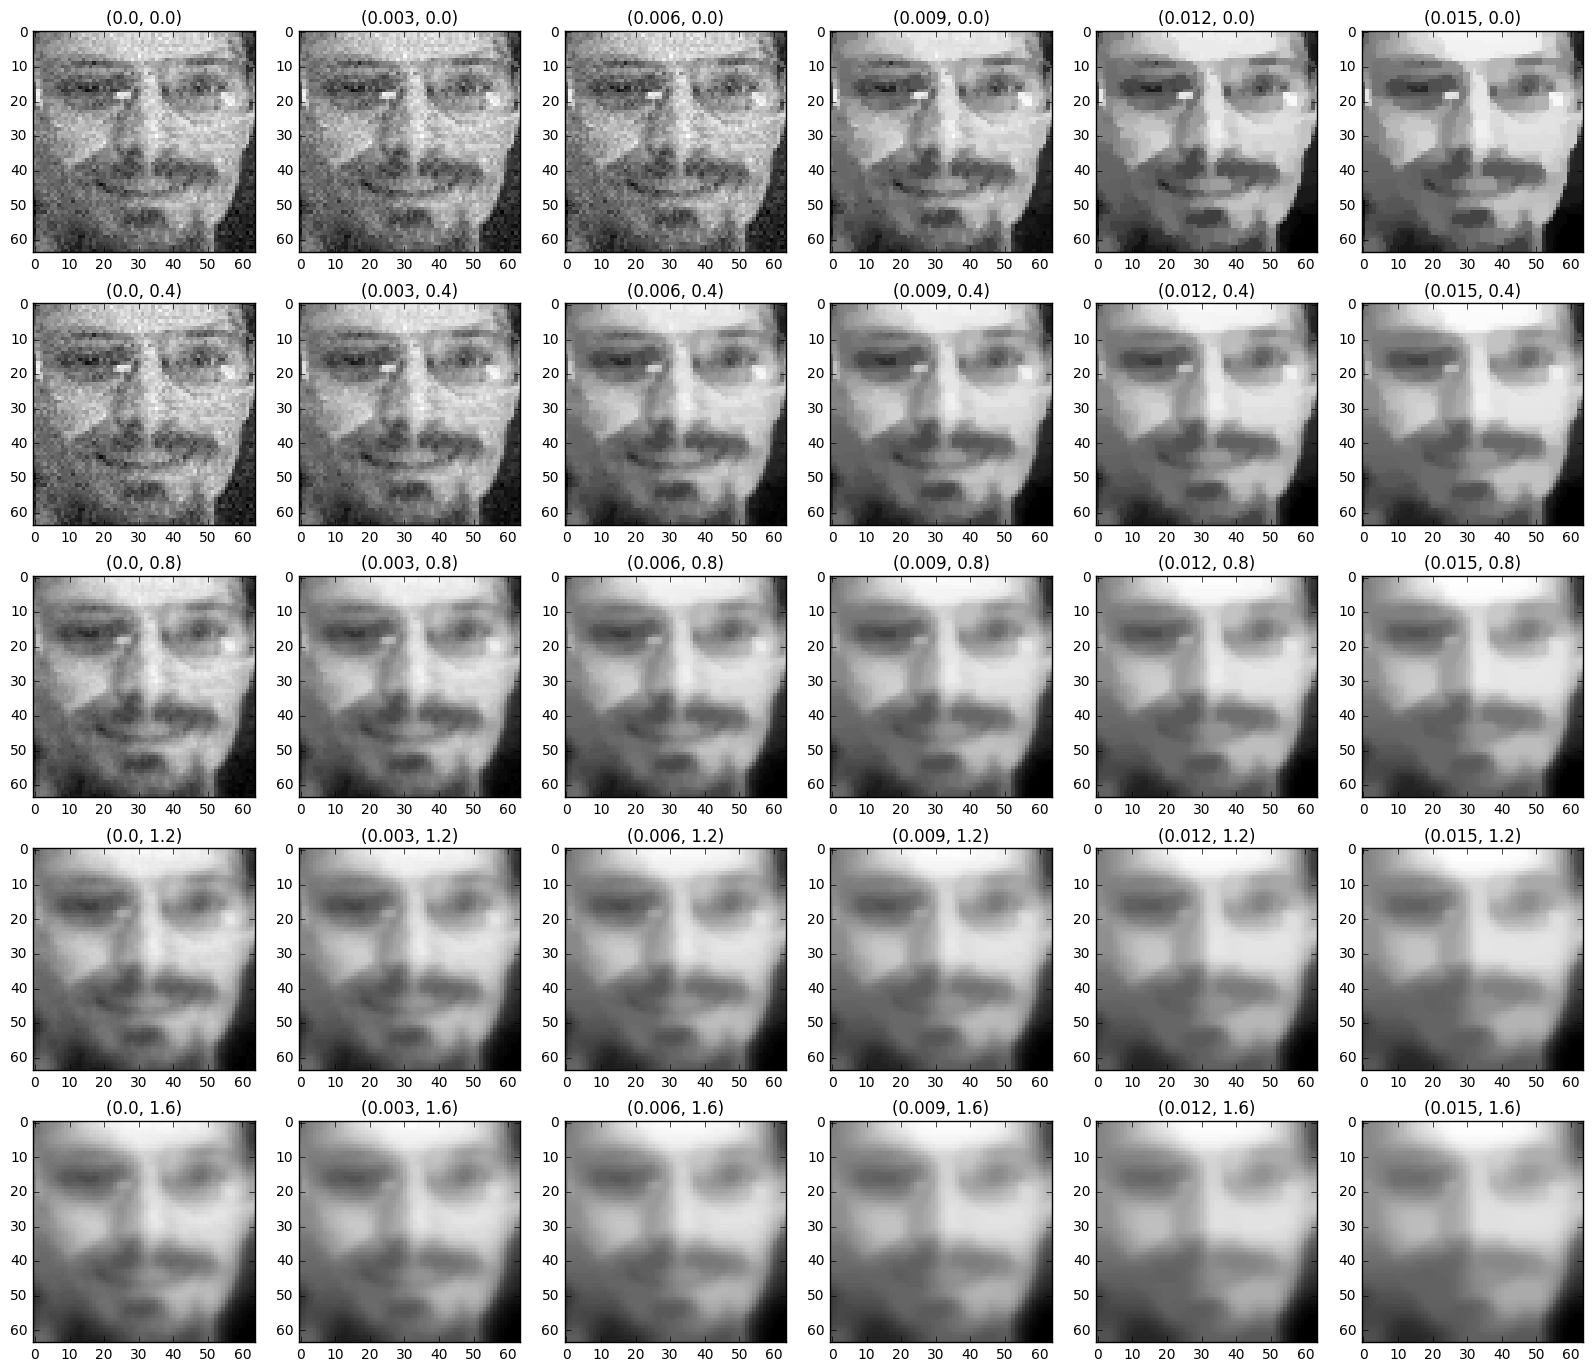

In [15]:
lb1 = [0.,0.003,0.006,0.009,0.012,0.015]
lb2 = [0.,0.4,0.8,1.2,1.6]

n1,n2 = len(lb1),len(lb2)
fig, axarr = plt.subplots(n2,n1,figsize=(20,17))

for i,l1 in enumerate(lb1):
    for j,l2 in enumerate(lb2):
        show_image(smooth_image(l1,l2),axarr[j,i],str((l1,l2)))